In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


In [4]:
import os
import shutil

# Path to the folder containing all images
source_folder = r'Data for task2\augmented_training'

# Destination folder for organized data
destination_folder = r'Data for task2\augmented_training_organized'

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)
count = 0

# Iterate over all files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith('.png'):  # Ensure only image files are processed
        # Extract the class name from the filename (e.g., 'user002' from 'user002_sakhar_018.png')
        class_name = filename.split('_')[0]

        # Create the class folder if it doesn't already exist
        class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        count += 1

        # Move the image to the corresponding class folder
        src_path = os.path.join(source_folder, filename)
        dst_path = os.path.join(class_folder, filename)
        shutil.move(src_path, dst_path)

print("Images have been organized into class-specific folders.")
print(f"count = {count}")


Images have been organized into class-specific folders.
count = 22800


In [5]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:
train_dir = r'Data for task2\augmented_training_organized'
val_dir = r'Data for task2\validation_organized'
test_dir = r'Data for task2\testing_organized'
# Image dimensions
IMG_SIZE = 224
BATCH_SIZE = 8

# Training Data Generator (No augmentation needed, only rescaling)
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation Data Generator (Rescaling only)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test Data Generator (Rescaling only)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 22800 images belonging to 82 classes.
Found 1628 images belonging to 82 classes.
Found 816 images belonging to 82 classes.


In [11]:
# Paths to your dataset in Google Drive
train_dir = r'Data for task2\augmented_training_organized'
val_dir = r'Data for task2\validation_organized'
test_dir = r'Data for task2\testing_organized'

# Only normalization for all datasets
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [12]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms)

# Data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print class names
print("Classes:", train_dataset.classes)


Classes: ['user001', 'user002', 'user003', 'user004', 'user005', 'user006', 'user007', 'user008', 'user009', 'user010', 'user011', 'user012', 'user013', 'user014', 'user015', 'user016', 'user017', 'user018', 'user019', 'user020', 'user021', 'user022', 'user023', 'user024', 'user025', 'user026', 'user027', 'user028', 'user029', 'user030', 'user031', 'user032', 'user033', 'user034', 'user035', 'user036', 'user037', 'user038', 'user039', 'user040', 'user041', 'user042', 'user043', 'user044', 'user045', 'user046', 'user047', 'user048', 'user049', 'user050', 'user051', 'user052', 'user053', 'user054', 'user055', 'user056', 'user057', 'user058', 'user059', 'user060', 'user061', 'user062', 'user063', 'user064', 'user065', 'user066', 'user067', 'user068', 'user069', 'user070', 'user071', 'user072', 'user073', 'user074', 'user075', 'user076', 'user077', 'user078', 'user079', 'user080', 'user081', 'user082']


In [13]:
# Load a pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier for your dataset
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move the model to the appropriate device
model = model.to(device)


In [14]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [18]:
# Training and validation loop
epochs = 20
best_val_acc = 0.0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print(f"Batch Loss: {loss.item():.4f}")
        # print(f"Batch Acc: {(predicted == labels).sum().item() / labels.size(0):.4f}")

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dataset)
    val_acc = correct / total
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), r"best_model.pth")
        print("Saved Best Model!")


Epoch 1/20
----------
Train Loss: 2.2351, Train Acc: 0.4346
Val Loss: 1.9069, Val Acc: 0.4859
Saved Best Model!
Epoch 2/20
----------
Train Loss: 2.2154, Train Acc: 0.4393
Val Loss: 1.8726, Val Acc: 0.5092
Saved Best Model!
Epoch 3/20
----------
Train Loss: 2.1895, Train Acc: 0.4500
Val Loss: 1.7759, Val Acc: 0.5369
Saved Best Model!
Epoch 4/20
----------
Train Loss: 2.2400, Train Acc: 0.4418
Val Loss: 1.7752, Val Acc: 0.5375
Saved Best Model!
Epoch 5/20
----------
Train Loss: 2.2238, Train Acc: 0.4472
Val Loss: 1.8251, Val Acc: 0.5154
Epoch 6/20
----------
Train Loss: 2.2185, Train Acc: 0.4502
Val Loss: 1.8959, Val Acc: 0.5154
Epoch 7/20
----------
Train Loss: 2.2258, Train Acc: 0.4444
Val Loss: 1.7359, Val Acc: 0.5510
Saved Best Model!
Epoch 8/20
----------
Train Loss: 2.2219, Train Acc: 0.4525
Val Loss: 1.7874, Val Acc: 0.5344
Epoch 9/20
----------
Train Loss: 2.2126, Train Acc: 0.4571
Val Loss: 1.7329, Val Acc: 0.5645
Saved Best Model!
Epoch 10/20
----------
Train Loss: 2.2136, Tra

KeyboardInterrupt: 

In [19]:
# Load the best model
model.load_state_dict(torch.load(r"best_model.pth"))
model.eval()

# Testing phase
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


C:\Users\nsrha\AppData\Local\Temp\ipykernel_34600\2357884141.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"best_model.pth"))


Test Accuracy: 0.5662


Test Accuracy: 0.5319, no finetuning
Epoch 1/10
----------
Train Loss: 3.3030, Train Acc: 0.2024
Val Loss: 2.3484, Val Acc: 0.3870
Saved Best Model!
Epoch 2/10
----------
Train Loss: 2.5702, Train Acc: 0.3357
Val Loss: 2.0581, Val Acc: 0.4496
Saved Best Model!
Epoch 3/10
----------
Train Loss: 2.3908, Train Acc: 0.3774
Val Loss: 1.9550, Val Acc: 0.4760
Saved Best Model!
Epoch 4/10
----------
Train Loss: 2.3347, Train Acc: 0.3940
Val Loss: 1.9954, Val Acc: 0.4822
Saved Best Model!
Epoch 5/10
----------
Train Loss: 2.2750, Train Acc: 0.4104
Val Loss: 1.9524, Val Acc: 0.4834
Saved Best Model!
Epoch 6/10
----------
Train Loss: 2.2474, Train Acc: 0.4225
Val Loss: 1.8892, Val Acc: 0.4932
Saved Best Model!
Epoch 7/10
----------
Train Loss: 2.2416, Train Acc: 0.4249
Val Loss: 1.9466, Val Acc: 0.4859
Epoch 8/10
----------
Train Loss: 2.2246, Train Acc: 0.4310
Val Loss: 1.8263, Val Acc: 0.5264
Saved Best Model!
Epoch 9/10
----------
Train Loss: 2.2324, Train Acc: 0.4348
Val Loss: 1.8483, Val Acc: 0.5123
Epoch 10/10
----------
Train Loss: 2.2047, Train Acc: 0.4419
Val Loss: 1.8903, Val Acc: 0.5080



Test Accuracy: 0.5662, no finetunning
Epoch 1/20
----------
Train Loss: 2.2351, Train Acc: 0.4346
Val Loss: 1.9069, Val Acc: 0.4859
Saved Best Model!
Epoch 2/20
----------
Train Loss: 2.2154, Train Acc: 0.4393
Val Loss: 1.8726, Val Acc: 0.5092
Saved Best Model!
Epoch 3/20
----------
Train Loss: 2.1895, Train Acc: 0.4500
Val Loss: 1.7759, Val Acc: 0.5369
Saved Best Model!
Epoch 4/20
----------
Train Loss: 2.2400, Train Acc: 0.4418
Val Loss: 1.7752, Val Acc: 0.5375
Saved Best Model!
Epoch 5/20
----------
Train Loss: 2.2238, Train Acc: 0.4472
Val Loss: 1.8251, Val Acc: 0.5154
Epoch 6/20
----------
Train Loss: 2.2185, Train Acc: 0.4502
Val Loss: 1.8959, Val Acc: 0.5154
Epoch 7/20
----------
Train Loss: 2.2258, Train Acc: 0.4444
Val Loss: 1.7359, Val Acc: 0.5510
Saved Best Model!
Epoch 8/20
----------
Train Loss: 2.2219, Train Acc: 0.4525
Val Loss: 1.7874, Val Acc: 0.5344
Epoch 9/20
----------
Train Loss: 2.2126, Train Acc: 0.4571
Val Loss: 1.7329, Val Acc: 0.5645
Saved Best Model!
Epoch 10/20
----------
Train Loss: 2.2136, Train Acc: 0.4547
Val Loss: 1.9020, Val Acc: 0.5240
Epoch 11/20
----------
Train Loss: 2.2221, Train Acc: 0.4547
Val Loss: 1.8876, Val Acc: 0.5129



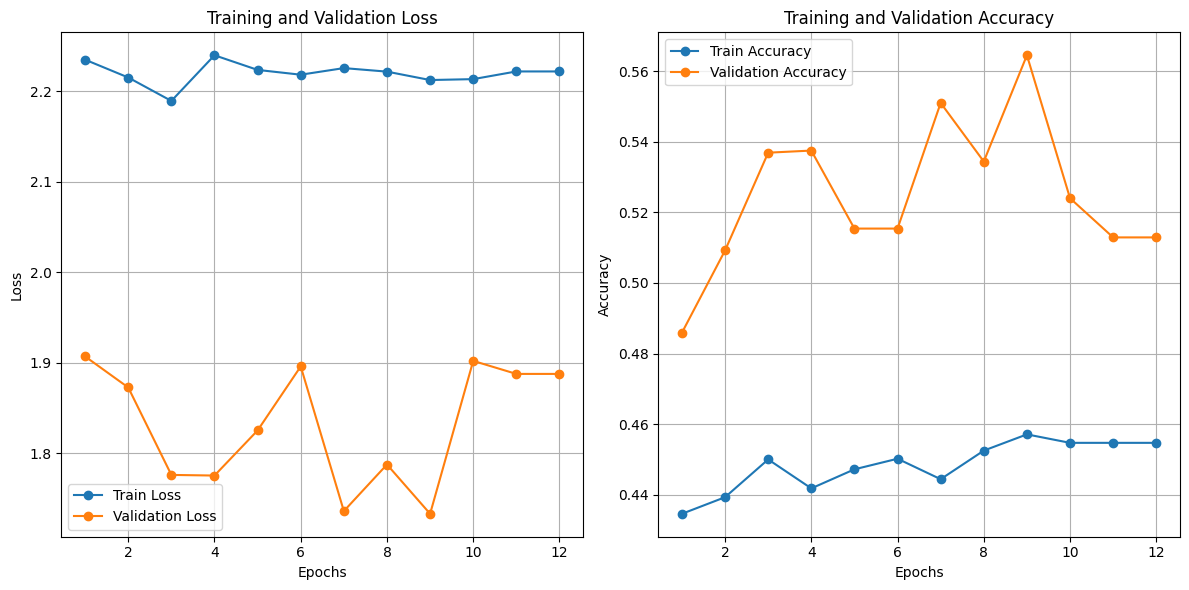

In [20]:
import matplotlib.pyplot as plt

# Data from training and validation logs
epochs = list(range(1, 13))
train_losses = [2.2351, 2.2154, 2.1895, 2.2400, 2.2238, 2.2185, 2.2258, 2.2219, 2.2126, 2.2136, 2.2221, 2.2221]
val_losses = [1.9069, 1.8726, 1.7759, 1.7752, 1.8251, 1.8959, 1.7359, 1.7874, 1.7329, 1.9020, 1.8876, 1.8876]
train_accuracies = [0.4346, 0.4393, 0.4500, 0.4418, 0.4472, 0.4502, 0.4444, 0.4525, 0.4571, 0.4547, 0.4547, 0.4547]
val_accuracies = [0.4859, 0.5092, 0.5369, 0.5375, 0.5154, 0.5154, 0.5510, 0.5344, 0.5645, 0.5240, 0.5129, 0.5129]

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Display the plots
plt.tight_layout()
plt.show()
